# SQL

Brief summary of key SQL 

## Intro

***Procedural*** programming languages define both the desired outcome and the process by which to achieve it. The procedural paradigm is a subset of the imperative paradigm.

***Non-procedural*** languages define the desired outcome, but omit the process - that is left to something/one else to figure out. (similarities with the declarative paradigm)

SQL is a non-procedural language: it uses statements to define the expected inputs and outputs; the database engine's ***optimiser*** works out an efficient execution path between the two.

The SQL language supports several different types of statements: 
- ***schema statements*** define the data structures stored in the database
- ***data statements*** query & manipulate the data in the database
- ***transaction statements*** manage changes to the database using transactions


sqlite will create a disk-based SQL database - with no server required - that lives in a file. 

To get started, we'll create a database called 'example.db' and create a connection to it:

In [1]:
import sqlite3
import os

db_path = 'example.db'
print(sqlite3.version_info)
if os.path.exists(db_path):
    os.remove(db_path)
conn = sqlite3.connect(db_path)

(2, 6, 0)


## Data types

| Category      | Data type   | Note             |
| :----------:  | :------:    | :--------------: |
| Characters    | char        | Fixed-length     |
| Characters    | varchar     | Variable-length  |
| Text          | tinytext    |                  |
| Text          | text        |                  |
| Text          | mediumtext  |                  |
| Text          | longtext    |                  |
| Integer       | tinyint     |                  |
| Integer       | smallint    |                  |
| Integer       | mediumint   |                  |
| Integer       | int         |                  |
| Integer       | bigint      |                  |
| Floating-point| float       |                  |
| Floating-point| double      |                  |
| Temporal      | date        |                  |
| Temporal      | datetime    |                  |
| Temporal      | timestamp   |                  |
| Temporal      | year        |                  |
| Temporal      | time        |                  |

### Characters

```SQL
char(20) /* fixed-length, max 255 bytes*/
varchar(280) /* variable-length, max 65 KB*/
```

### Text

```SQL
tinytext /* 255 bytes*/
text /* 65 KB*/
mediumtext /* 16.8 MB*/
longtext /* 4.3 GB*/
```

### Numerical

#### Integer types

```SQL
tinyint
smallint
mediumint
int
bigint
```

#### Floating-point types

```SQL
float
double
```

### Temporal

```SQL
date
datetime
timestamp
year
time
```



## Creating tables

Shape of a table-creation statement

```SQL
CREATE TABLE <table_name>
(
    <col_name> <data_type> <other_args>, /* pattern */
    reference_num INT UNSIGNED, /* example 1 */
    name VARCHAR(30), /* example 2 */
    ...
);
```

### Constraints

Alongside the column definition entries, we can also add constraints on their values

```SQL
CONSTRAINT <constraint_name> PRIMARY KEY (<column_name>) /* Make <column_name> the primary key */
CONSTRAINT <constraint_name> PRIMARY KEY (<column_name1>, <column_name2>) /* Create a composite primary key */
CONSTRAINT <constraint_name> FOREIGN KEY (<column_name>) REFERENCES <table_name> (<column_name>) /* Constrain the values in a column to those that appear in the column of another table */
```

To enforce the values that a column can take, there is also a `CHECK` keyword that can be used to specify the list of acceptable values & enforce a check against them.

In the case of MySQL, we use `ENUM` instead of `CHECK`.

In [2]:
def check_tables(conn):
    """Print a list of table names for the connected DB"""
    cursor = conn.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    result = cursor.fetchall()
    cursor.close()
    return result
    
check_tables(conn)

[]

In order to motivate my exploration of SQL, I'm going to create a (weakly realistic, but heavily simplified) synthetic dataset which allows me to take advantage of the various features of the language.

### Creating synthetic data for our example db

In [3]:
from collections import namedtuple

COUNTRIES = ('UK', 'FRANCE', 'RUSSIA', 'CANADA', 'BRAZIL', 'AUSTRALIA')
YEARS = tuple(i for i in range(2000, 2021))

WeatherDistribution = namedtuple('WeatherDistribution', ['temp_mean', 'temp_var', 'precip_mean', 'precip_var'])
weather_distributions = {
    'UK': WeatherDistribution(10, 25, 700, 1000),
    'FRANCE': WeatherDistribution(12, 30, 500, 900),
    'RUSSIA': WeatherDistribution(5, 70, 600, 1200),
    'CANADA': WeatherDistribution(10, 70, 600, 800)
}

In [4]:
import numpy as np

def generate_temperature_data(month_arr, mean, var):
    """Generate a synthetic time-series of temperature values"""
    return mean + np.sqrt(var) * np.random.randn(len(month_arr))

def generate_precipitation_data(month_arr, mean, var):
    """Generate a synthetic time-series of precipitation values"""
    return np.clip(mean + np.sqrt(var) * np.random.randn(len(month_arr)), 0., 50)

In [5]:
import pandas as pd

dates = pd.date_range(f'{YEARS[0]}-01-01', f'{YEARS[-1]}-12-31', freq='D')
weather_dfs = []
for country in COUNTRIES[:4]:
    # Get the relevant weather distribution for the country being processed
    weather_dist = weather_distributions.get(country)
    # Create an index object for the dataframe that will hold the synthetic data
    idx = pd.MultiIndex.from_arrays([[country for date in dates], dates], names=('country', 'date'))
    # Generate synthetic data
    temp = generate_temperature_data(month_arr=idx.get_level_values('date').month, mean=weather_dist.temp_mean, var=weather_dist.temp_var)
    precip = generate_precipitation_data(month_arr=idx.get_level_values('date').month, mean=weather_dist.precip_mean/365, var=weather_dist.precip_var)
    # Collect a new dataframe with our fresh weather data
    weather_dfs.append(pd.DataFrame(data={'temp': temp, 'precip': precip}, index=idx))
df = pd.concat(weather_dfs)
df

temp     precip
country date                            
UK      2000-01-01  15.142035   0.000000
        2000-01-02  13.189532  32.625507
        2000-01-03   3.552117   0.000000
        2000-01-04  12.439774  13.648547
        2000-01-05  11.854813   0.000000
...                       ...        ...
CANADA  2020-12-27  -1.839484  11.316317
        2020-12-28  11.628753   0.000000
        2020-12-29   3.531426   0.000000
        2020-12-30   6.735432  17.092657
        2020-12-31  22.834610  14.787237

[30684 rows x 2 columns]

### Creating database tables

In [6]:
CREATE_COUNTRY_TABLE = '''
CREATE TABLE country
(
    id INTEGER PRIMARY KEY,
    name VARCHAR(20) NOT NULL
);
'''

In [7]:
CREATE_WEATHER_TABLE = '''
CREATE TABLE weather
(
    id INTEGER PRIMARY KEY,
    country_id INTEGER,
    date DATE NOT NULL,
    temp FLOAT,
    precip FLOAT,
    
    CONSTRAINT fk_weather_country FOREIGN KEY (country_id) REFERENCES country (id)
);
'''

In [8]:
def create_tables(conn, *table_schemas):
    """Create new SQL tables"""
    cursor = conn.cursor()
    for schema in table_schemas:
        cursor.execute(schema)
    conn.commit()

In [9]:
create_tables(conn, CREATE_COUNTRY_TABLE, CREATE_WEATHER_TABLE)

In [10]:
tables = check_tables(conn)
assert len(tables) == 2
print(tables)

[('country',), ('weather',)]


### Insert the data into the tables

#### `country` table

In [11]:
INSERT_COUNTRY_DATA = '''
INSERT INTO country (name) VALUES (?)
'''

In [12]:
cursor = conn.cursor()
cursor.executemany(INSERT_COUNTRY_DATA, [(c,) for c in COUNTRIES])
conn.commit()

In [13]:
ALL_COUNTRIES_QUERY = '''SELECT * from country'''

results = cursor.execute(ALL_COUNTRIES_QUERY)
country_id_map = {result[1]: result[0] for result in results}
country_id_map

{'UK': 1, 'FRANCE': 2, 'RUSSIA': 3, 'CANADA': 4, 'BRAZIL': 5, 'AUSTRALIA': 6}

#### `weather` table

In [14]:
INSERT_WEATHER_DATA = '''
INSERT INTO weather (country_id, date, temp, precip) VALUES (?, ?, ?, ?)
'''

In [15]:
def prepare_weather_record(record):
    return (country_id_map[record.country], str(record.date.date()), record.temp, record.precip)

cursor = conn.cursor()
cursor.executemany(INSERT_WEATHER_DATA, map(prepare_weather_record, df.round(1).to_records()))
conn.commit()

In [16]:
COUNT_WEATHER_QUERY = '''SELECT COUNT(id) from weather'''

result = cursor.execute(COUNT_WEATHER_QUERY).fetchall()
print(result)

[(30684,)]


## Manipulating data


### Joins

One of the joys of normalisation is that we create single instances of information that can be associated with many other records of information elsewhere in the database; having only one place to update each ensures it is always the most up-to-date version and avoids inconsistencies.

But it also means that the data we want for a given use-case will often be spread across multiple tables and needs to be brought together to make it useful.

**Joins** allow us to do this in the database, rather than in our application code: which is likely to be  more efficient and less error-prone.

1. Cartesian product
1. Inner join
1. Outer join

#### Cartesian product

If you include a `JOIN` statement in your query, but don't provide an `ON <...> = <...>` clause, then the query will return the cartesian product of the two tables; ie. every possible combination of the two tables.
If table 1 has $N$ rows and table 2 has $M$ rows, then we'll end up with a result set of $N \times M$ rows.

This is known as a `cross join`, and is rarely what we intended to ask for...

```SQL
SELECT
    alias_1.col_a
    , alis_1.col_b
    , alias_2.col_x
    , alias_2.col_y
FROM
    <table_name_1> alias_1
    CROSS JOIN
    <table_name_2> alias_2
```

#### Inner join

Inner joins are the default join type. If you provide the `ON t.p_id = p.id` clause at the end of the join statement, but don't specify what type of join you would like (ie. `INNER` or `OUTER`), then you will get an inner join (but you ***should*** always say which type of join you want!).

```SQL
SELECT
    alias_1.col_a
    , alis_1.col_b
    , alias_2.col_x
    , alias_2.col_y
FROM
    <table_name_1> alias_1
    INNER JOIN
    <table_name_2> alias_2
    ON
    alias_1.col_name_1 = alias_2.col_name_2;
```

Returns a record only when a match exists on both sides of the join. Any records with values in the columns on which we're joining that only appear in one of the join tables, then that record will be omitted from the result set.

> `IN`ner joins give us the `IN`tersection of the two tables.

Because we're dealing with the intersection of the two tables, it doesn't make sense to distinguish between `LEFT` & `RIGHT` joins.

#### Outer join

Outer joins include the full set of values from specified tables in the join, even when there isn't a match on both sides.
For any columns from the table without matches that are included in the results, we'll just get `NULL` values.

Flavours:
- `LEFT OUTER JOIN`
- `RIGHT OUTER JOIN`
- `FULL OUTER JOIN`

```SQL
SELECT
    alias_1.col_a
    , alis_1.col_b
    , alias_2.col_x
    , alias_2.col_y
FROM
    <table_name_1> alias_1
    LEFT OUTER JOIN
    <table_name_2> alias_2
    ON
    alias_1.col_name_1 = alias_2.col_name_2;
```

> left joins are used by convention, so try to avoid right joins in practice

If you omit the `OUTER` and just use `LEFT / RIGHT JOIN` then this will always yield an outer join.

In [34]:
def column_names(cursor):
    return [desc[0] for desc in cursor.description]

def run_query(query_string, conn):
    """run the query, return the result set and column names"""
    cursor = conn.cursor()
    return cursor.execute(query_string).fetchall(), column_names(cursor)

def summarise_query_results(query_string, conn, max_items=10):
    """Print a short summary of the query results"""
    result, columns = run_query(query_string, conn)
    print(f"{len(result)} rows returned")
    print('Column names: ', columns)
    limit = max_items if len(result) > max_items else len(result)
    for i in range(limit):
        print(result[i])
    return result

In [35]:
GET_WEATHER_QUERY_INNER = '''
SELECT
    c.id as country_id
    , c.name as country_name
    , COUNT(w.date) as weather_records
FROM
    country c
    INNER JOIN
    weather w
ON w.country_id = c.id
GROUP BY c.id
'''

In [39]:
result = summarise_query_results(GET_WEATHER_QUERY_INNER, conn)

4 rows returned
Column names:  ['country_id', 'country_name', 'weather_records']
(1, 'UK', 7671)
(2, 'FRANCE', 7671)
(3, 'RUSSIA', 7671)
(4, 'CANADA', 7671)


In [37]:
GET_WEATHER_QUERY_OUTER = '''
SELECT
    c.id as country_id
    , c.name as country_name
    , COUNT(w.date) as weather_records
FROM
    country c
    LEFT OUTER JOIN
    weather w
ON w.country_id = c.id
GROUP BY c.id
'''

In [40]:
result = summarise_query_results(GET_WEATHER_QUERY_OUTER, conn)

6 rows returned
Column names:  ['country_id', 'country_name', 'weather_records']
(1, 'UK', 7671)
(2, 'FRANCE', 7671)
(3, 'RUSSIA', 7671)
(4, 'CANADA', 7671)
(5, 'BRAZIL', 0)
(6, 'AUSTRALIA', 0)


In [41]:
GET_WEATHER_QUERY_CROSS = '''
SELECT
    c.id as country_id
    , c.name as country_name
    , COUNT(w.date) as weather_records
FROM
    country c
    CROSS JOIN
    weather w
GROUP BY c.id
'''

In [42]:
result = summarise_query_results(GET_WEATHER_QUERY_CROSS, conn)

6 rows returned
Column names:  ['country_id', 'country_name', 'weather_records']
(1, 'UK', 30684)
(2, 'FRANCE', 30684)
(3, 'RUSSIA', 30684)
(4, 'CANADA', 30684)
(5, 'BRAZIL', 30684)
(6, 'AUSTRALIA', 30684)


#### Joining many tables

In the examples above, we are joining 2 tables together.

In reality, we will often want to join more than 2 tables together. Are there additional considerations to bear in mind when joining on more than 2 tables?

Other than wanting to avoid doing ***too many*** joins in any given query, no: the order in which we write the joins doesn't make any difference to the order in which the joins are executed because the optimiser will take its own view on how best to complete the query.

## Aggregations & analytics

- windows
- pivots
- rankings
- histograms

In [46]:
MONTHLY_PARTITION_QUERY = '''
SELECT
    c.name as country_name
    , strftime('%Y-%m', w.date) as yr_month
    , w.date
    , w.precip as daily_precip
    , sum(w.precip) OVER (partition by strftime('%Y-%m', w.date) ROWS unbounded preceding) as sum_to_date
    , sum(w.precip) OVER (ORDER BY w.date ROWS BETWEEN 9 PRECEDING AND 0 FOLLOWING) rolling_10d_precip_by_items
    , sum(w.precip) OVER (ORDER BY w.date RANGE BETWEEN 9 PRECEDING AND 0 FOLLOWING) rolling_10d_precip_by_dates
    , sum(w.precip) OVER (partition by strftime('%Y-%m', w.date)) as total_monthly_precip
FROM
    country c
    INNER JOIN
    weather w 
    ON
    c.id = w.country_id
WHERE
    c.id = 1
'''

In [47]:
import pandas as pd

In [50]:
result, cols = run_query(MONTHLY_PARTITION_QUERY, conn)
df = pd.DataFrame(result, columns=cols)
df.head()

,country_name,yr_month,date,daily_precip,sum_to_date,rolling_10d_precip_by_items,rolling_10d_precip_by_dates,total_monthly_precip
0,UK,2000-01,2000-01-01,0.0,0.0,0.0,0.0,354.7
1,UK,2000-01,2000-01-02,32.6,32.6,32.6,32.6,354.7
2,UK,2000-01,2000-01-03,0.0,32.6,32.6,0.0,354.7
3,UK,2000-01,2000-01-04,13.6,46.2,46.2,13.6,354.7
4,UK,2000-01,2000-01-05,0.0,46.2,46.2,0.0,354.7


In [56]:
import plotly.graph_objects as go

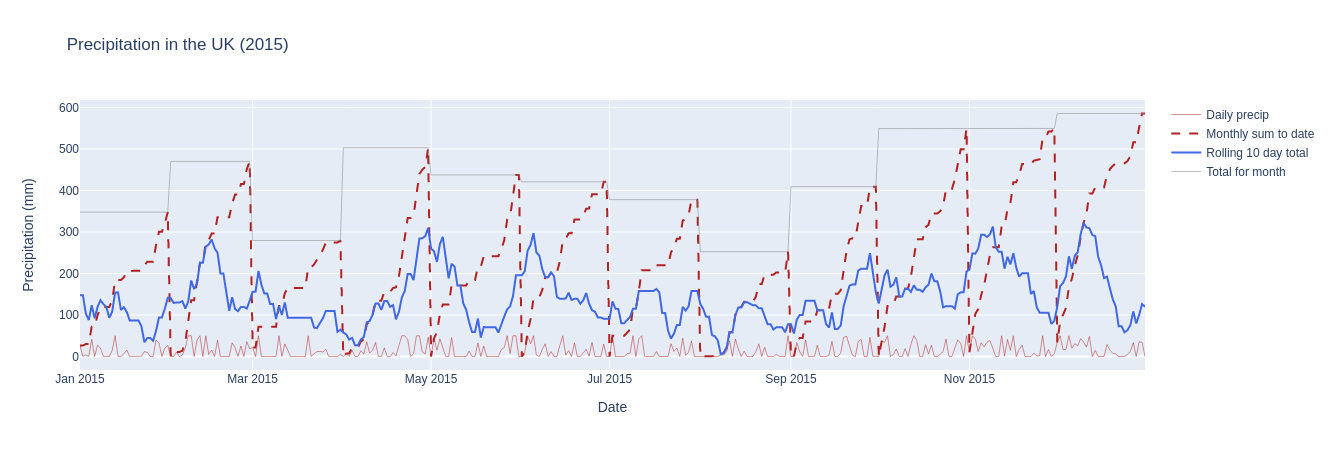

In [74]:
df_2015 = df[(df.date >= "2015-01-01") & (df.date <= "2015-12-31")]

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_2015.date, y=df_2015.daily_precip, name='Daily precip',line=dict(color='firebrick', width=.5)))
fig.add_trace(go.Scatter(x=df_2015.date, y=df_2015.sum_to_date, name='Monthly sum to date',line=dict(color='firebrick', width=2, dash='dash')))
fig.add_trace(go.Scatter(x=df_2015.date, y=df_2015.rolling_10d_precip_by_items, name='Rolling 10 day total',line=dict(color='royalblue', width=2)))
fig.add_trace(go.Scatter(x=df_2015.date, y=df_2015.total_monthly_precip, name='Total for month',line=dict(color='grey', width=.5)))
fig.update_layout(title='Precipitation in the UK (2015)',xaxis_title='Date', yaxis_title='Precipitation (mm)')
fig.show()